In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.util import read_obj_uvs
from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip
from pytorch3d.io import load_objs_as_meshes

torch.set_grad_enabled(False)

device = "cuda"
mesh_path = "data/meshes/mixamo-human.obj"

# read mesh
verts_uvs, faces_uvs = read_obj_uvs(mesh_path)
mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

# Setup Texturing Views

In [2]:
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.ipython_utils import display_vid
from pytorch3d.renderer import FoVPerspectiveCameras

n_frames = 5
angles = torch.linspace(-20, 20, n_frames)
angles = [0, 45, 135, 180, 225, 315]
elevs = [20]

all_angles = angles * len(elevs)
all_elevs = torch.cat([torch.Tensor([e] * len(angles)) for e in elevs])

R, T = turntable_extrinsics(dists=1.5, angles=all_angles, elevs=all_elevs)
view_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=40)
view_meshes = mesh.extend(len(view_cams))

depths = render_depth_map(view_meshes, view_cams)
display_vid(pil_frames_to_clip(depths))

In [3]:
from text3d2video.utilities.camera_placement import cam_view_prompt

prompt_views = []
for a, e in zip(all_angles, all_elevs):
    suffix = cam_view_prompt(a, e)
    prompt_views.append(suffix)

print(prompt_views)

['front', 'front', 'back', 'back', 'back', 'front']


# Texturing

In [4]:
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texturing_pipeline import TexturingPipeline
from diffusers import DDIMScheduler

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(
    TexturingPipeline, sd_repo, controlnet_repo, scheduler_class=DDIMScheduler
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [46]:
from text3d2video.noise_initialization import UVNoiseInitializer
from text3d2video.pipelines.texturing_pipeline import TexturingConfig
from text3d2video.sd_feature_extraction import AttnType, BlockType, find_attn_layers

sa_up_layers = find_attn_layers(
    pipe.unet,
    block_types=[BlockType.MID, BlockType.UP],
    layer_types=[AttnType.SELF_ATTN],
)

layers_factor = 1.0
max_layer_index = int(len(sa_up_layers) * layers_factor)

module_paths = sa_up_layers[:max_layer_index]

cfg = TexturingConfig(
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

prompt = "Abraham Lincoln"
prompts = [f'{prompt}, {view} view' for view in prompt_views]

In [47]:
from text3d2video.sd_feature_extraction import AttnLayerId


layers = [AttnLayerId.parse_module_path(m) for m in module_paths]
layer_resolutions = list(set([l.layer_resolution(pipe.unet) for l in layers]))

# map each layer to an index in resolution list
layer_res_index = {
    layer.module_path(): layer_resolutions.index(layer.layer_resolution(pipe.unet))
    for layer in layers
}


In [48]:
noise_initializer = UVNoiseInitializer()

generator = torch.Generator(device="cuda")
generator.manual_seed(0)

video_frames = pipe(
    prompts,
    view_meshes,
    view_cams,
    verts_uvs,
    faces_uvs,
    conf=cfg,
    generator=generator,
)

100%|██████████| 15/15 [00:38<00:00,  2.53s/it]


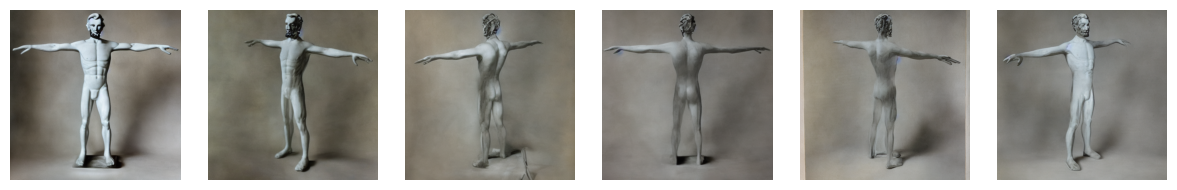

In [49]:
from text3d2video.utilities.ipython_utils import display_ims

display_ims(video_frames)

In [50]:
import os
from pathlib import Path
from text3d2video.utilities.tensor_writing import H5logger

logged_features = H5logger(Path("features.h5"))
logged_features.open_read()
_ = os.system("du -h features.h5")

3,9G	features.h5


In [51]:
from einops import rearrange

from text3d2video.utilities.h5_util import dataset_to_tensor

logged_features.open_read()

module = module_paths[-1]
texture_datasets = logged_features.read_datasets(f'qrys_cond/{module}')
texture_datasets = sorted(texture_datasets, key=lambda t: t.attrs['t'], reverse=True)
textures = [dataset_to_tensor(tex) for tex in texture_datasets]
textures = torch.stack(textures)
textures = rearrange(textures, 'b h w c -> b c h w')
textures.shape

torch.Size([15, 320, 192, 192])

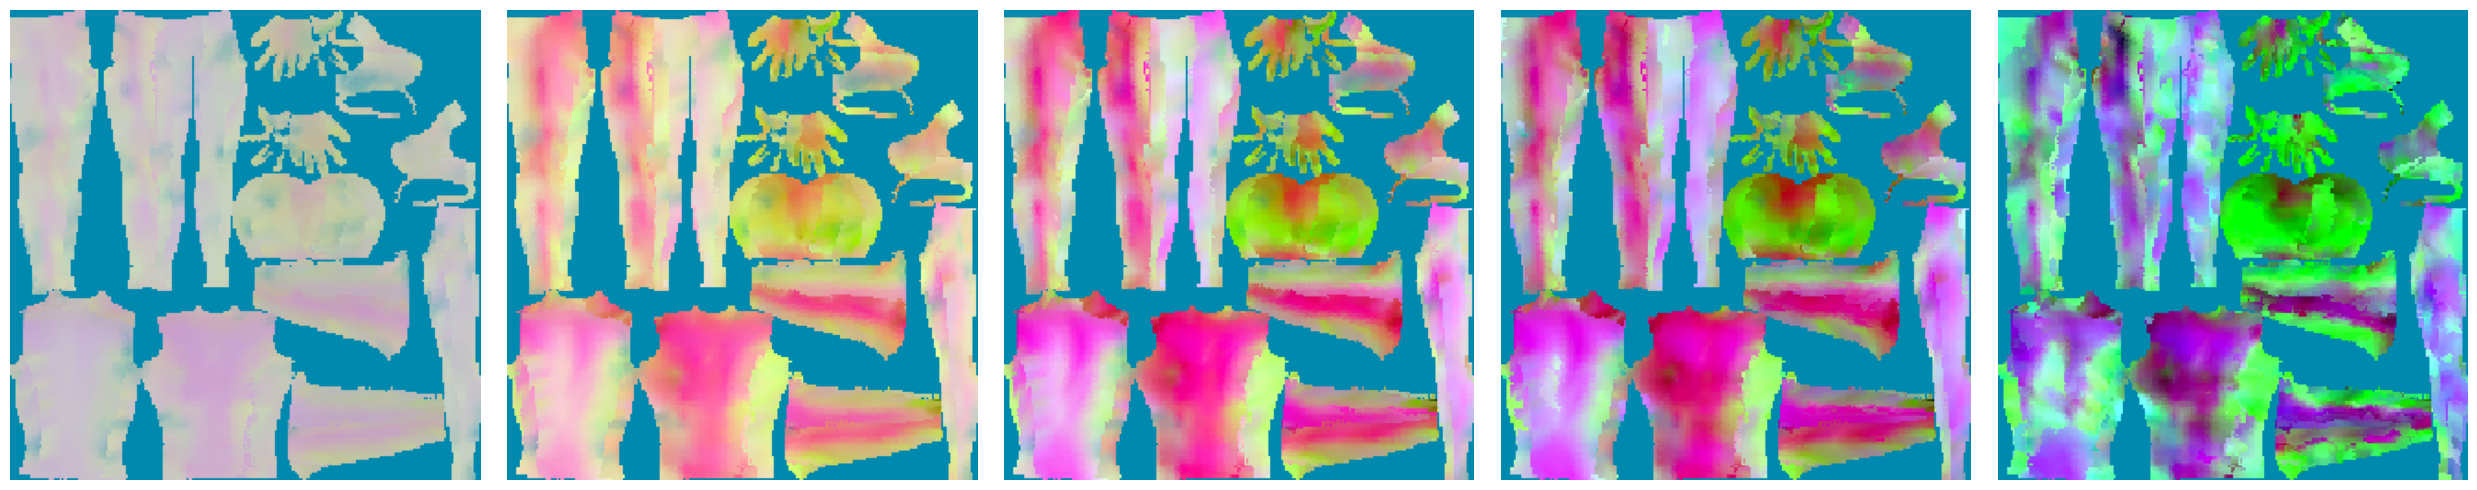

In [52]:
from einops import rearrange

import torchvision.transforms.functional as TF
from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.util import ordered_sample
from text3d2video.utilities.ipython_utils import display_ims

mid_idx = len(textures) // 2

features = rearrange(textures[mid_idx], "d h w -> (h w) d")
pca = RgbPcaUtil.init_from_features(features)
texture_ims = [pca.feature_map_to_rgb_pil(tex) for tex in textures]
texture_ims = [
    TF.resize(tex, (256, 256), interpolation=TF.InterpolationMode.NEAREST)
    for tex in texture_ims
]

display_ims(ordered_sample(texture_ims, 5), scale=5)

In [53]:
from text3d2video.utilities.ipython_utils import display_ims

display_vid(pil_frames_to_clip(texture_ims))

In [54]:
from text3d2video.pipelines.rd_2_pipeline import ReposableDiffusion2Pipeline

pipe_injection = load_pipeline(
    ReposableDiffusion2Pipeline, sd_repo, controlnet_repo, scheduler_class=DDIMScheduler
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [55]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag('mma:latest')
indices = anim.frame_indices(20)
cams, meshes = anim.load_frames(indices)
anim_verts_uvs, anim_faces_uvs = anim.uv_data()

In [56]:
from text3d2video.pipelines.rd_2_pipeline import ReposableDiffusionConfig

rd_config = ReposableDiffusionConfig(
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=1.0,
    attend_to_self_kv=False,
    mean_features_weight=0.0,
    chunk_size=5,
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(2)

noise_initializer = UVNoiseInitializer()

frames_injection = pipe_injection(
    "Deadpool",
    meshes,
    cams,
    anim_verts_uvs,
    anim_faces_uvs,
    rd_config,
    noise_initializer,
    logged_features,
    generator=generator,
)

100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


In [57]:
display_vid(pil_frames_to_clip(frames_injection))

# Rendering Texture

In [43]:
from text3d2video.backprojection import project_visible_texels_to_camera

uv_res = 1000
texel_xys = []
texel_uvs = []
for cams, view_mesh in zip(view_cams, view_meshes):
    projection = project_visible_texels_to_camera(
        view_mesh, cams, verts_uvs, faces_uvs, uv_res, raster_res=3000
    )
    texel_xys.append(projection.xys)
    texel_uvs.append(projection.uvs)

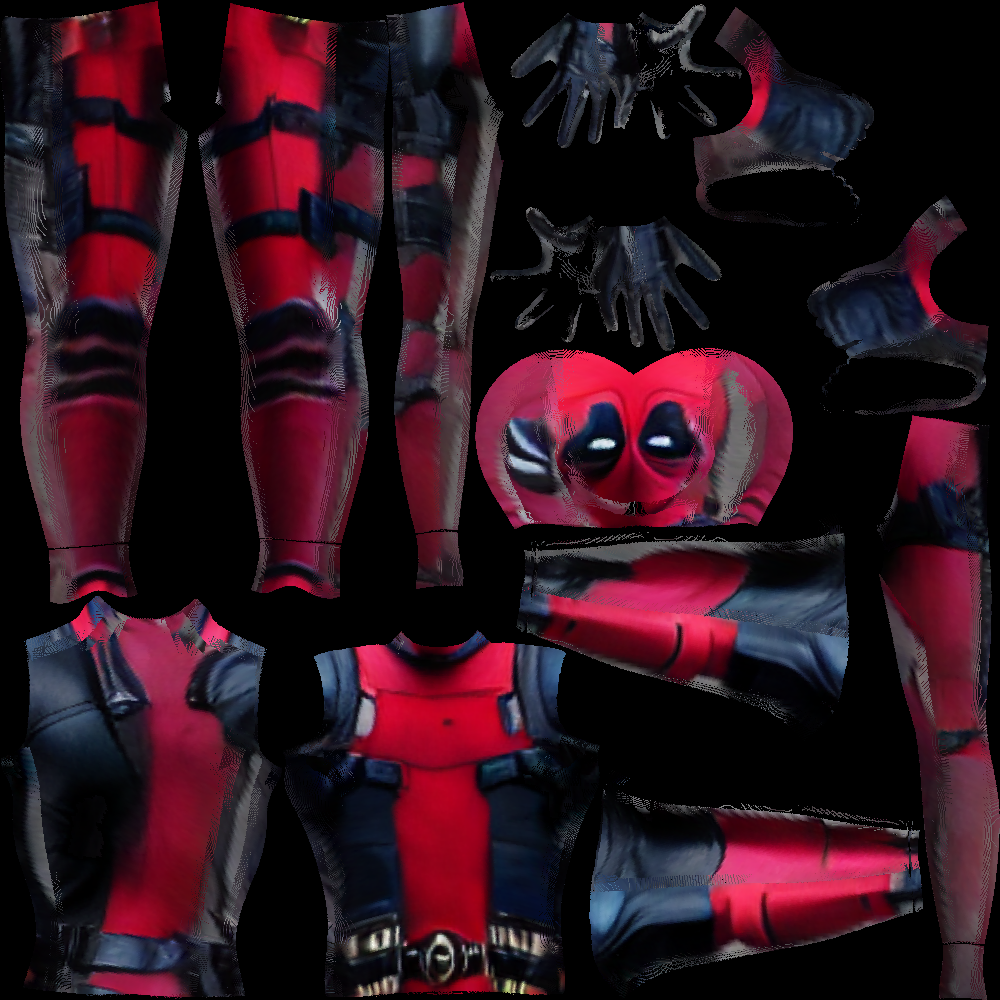

In [44]:
from text3d2video.backprojection import aggregate_views_uv_texture
import torchvision.transforms.functional as TF

texture_ims = [TF.to_tensor(x) for x in video_frames]
texture_ims = torch.stack(texture_ims).to(device)
uv_map = aggregate_views_uv_texture(
    texture_ims, uv_res, texel_xys, texel_uvs, interpolation_mode='bilinear'
)

TF.to_pil_image(uv_map.permute(2, 0, 1))

In [45]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import make_mesh_renderer, make_repeated_uv_texture

renderer = make_mesh_renderer()

anim = AnimationArtifact.from_wandb_artifact_tag('mma:latest')
indices = anim.frame_indices(20)
cams, mesh = anim.load_frames(indices)
vid_verts_uvs, vid_faces_uvs = anim.uv_data()

mesh.textures = make_repeated_uv_texture(uv_map, vid_faces_uvs, vid_verts_uvs, N=len(cams))

renders = renderer(mesh, cameras=cams)
renders_pil = [TF.to_pil_image(r) for r in renders]
display_vid(pil_frames_to_clip(renders_pil))